In [1]:
import numpy as np
import pandas as pd

import os
import math
import time
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [2]:
df_news = pd.read_excel("/content/news_share_data.xlsx")
df_news.head()

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,7014291,It's Time for a YouTube Competitor,It was reported last week that Yahoo is gettin...,2014-03-31,0.640816,5,3,1,4.579592,5,...,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.024490,0.25,0.25,1600
1,7014327,The Ultimate Roundup of 2014's Biggest April F...,April Fools' marks the day when pranking goes ...,2014-04-01,0.549618,4,1,0,4.636704,7,...,3581.094,2556.367,8500.000,0.410707,0.180934,0.044944,0.003745,0.00,0.00,1500
2,7014304,A Selfie and One Garish Jacket: How the Red So...,The 2013 World Series champion Boston Red Sox ...,2014-04-01,0.577236,8,1,0,4.627451,7,...,3852.800,3018.167,2076.333,0.397545,0.044864,0.035294,0.019608,0.00,0.00,1400
3,7031995,African Telecom Proposes More Diverse Emoticons,Less than a week after Apple pledged to make i...,2014-04-01,0.525896,4,1,0,5.083665,9,...,3581.094,1871.403,2200.000,0.491578,0.157620,0.047809,0.011952,0.00,0.00,1300
4,6541359,"Google to Launch Improved Android Camera App, ...",Android users may soon see a series of new fea...,2014-04-01,0.588889,6,9,0,4.336022,7,...,8453.451,5155.323,805.000,0.628535,0.078497,0.053763,0.034946,0.00,0.00,3000


In [3]:
df_news.columns

Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

In [4]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   article_id                  1003 non-null   int64         
 1   title                       1003 non-null   object        
 2   text                        1003 non-null   object        
 3   published_date              1003 non-null   datetime64[ns]
 4   unique_tokens_rate          1003 non-null   float64       
 5   num_hrefs                   1003 non-null   int64         
 6   num_imgs                    1003 non-null   int64         
 7   num_videos                  1003 non-null   int64         
 8   average_token_length        1003 non-null   float64       
 9   num_keywords                1003 non-null   int64         
 10  data_channel                1003 non-null   object        
 11  min_avg_key                 1003 non-null   float64     

In [5]:
df_news.shape

(1003, 22)

In [6]:
df_news.isnull().sum()

article_id                    0
title                         0
text                          0
published_date                0
unique_tokens_rate            0
num_hrefs                     0
num_imgs                      0
num_videos                    0
average_token_length          0
num_keywords                  0
data_channel                  0
min_avg_key                   0
max_avg_key                   0
avg_avg_key                   0
href_avg_shares               0
global_subjectivity           0
global_sentiment_polarity     0
global_rate_positive_words    0
global_rate_negative_words    0
title_subjectivity            0
title_sentiment_polarity      0
shares                        0
dtype: int64

In [7]:
df_news = df_news[df_news['title'].apply(lambda x: len(x.split())>4)]
print("Total number of articles after removal of title with short title:", df_news.shape[0])

Total number of articles after removal of title with short title: 1000


In [8]:
df_news.shape

(1000, 22)

Summary Statistics of Shares:


,shares
count,1000.000000
mean,4243.046000
std,22641.282639
min,58.000000
25%,1000.000000
50%,1600.000000
75%,3100.000000
max,663600.000000


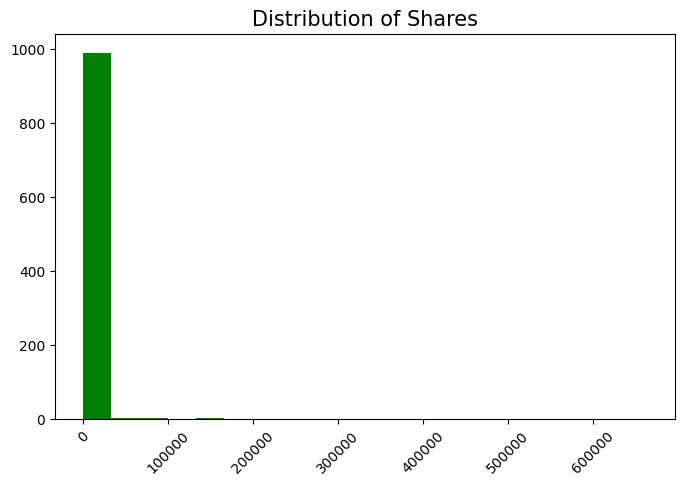

In [14]:
print("Summary Statistics of Shares:")
display(df_news[['shares']].describe())

plt.figure(figsize=(8,5))
plt.hist(df_news['shares'],bins=20, color = 'g')
plt.title("Distribution of Shares",size=15)
plt.xticks(rotation=45)
plt.show()

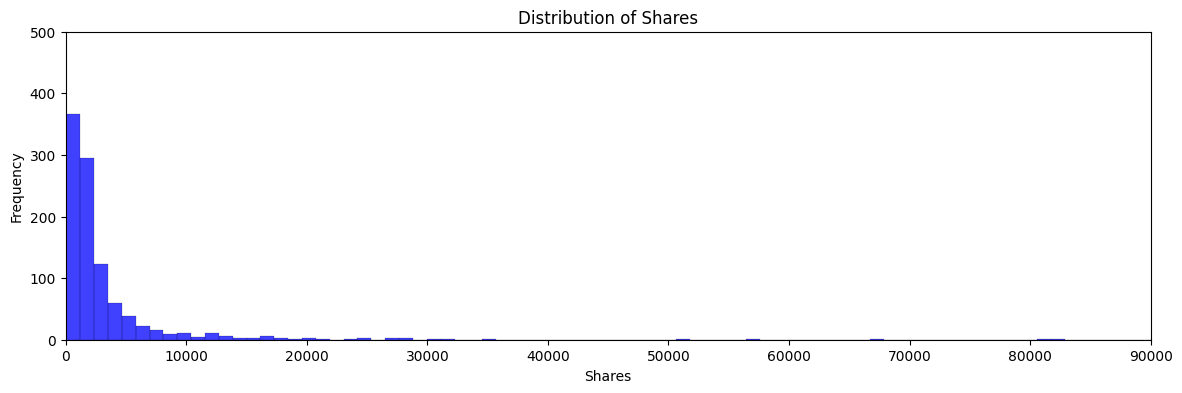

In [15]:
# Distribution of shares
array_shares = df_news['shares']

plt.figure(figsize=(14,4))
sns.histplot(array_shares, color = 'b', bins= 577, cbar= True)
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.title('Distribution of Shares')
plt.xlim(0, 90000)  # Set the y-axis limit
plt.ylim(0, 500)  # Set the y-axis limit
plt.show()


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Text preprocessing

In [29]:
#for weekday
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_news['weekday'] = df_news['published_date'].apply(lambda x: pd.to_datetime(x).day_name())

#for weekend
weekend_names = ['Friday', 'Saturday']

# Creating a binary indicator for the weekend
df_news['is_weekend'] = df_news['weekday'].apply(lambda x: 1 if x in weekend_names else 0)

# Extracting month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_news['month'] = df_news['published_date'].apply(lambda x: month_names[pd.to_datetime(x).month - 1])

df_news.sample(n=5)

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares,weekday,is_weekend,month
408,7029705,YouTube Files a Complaint in Turkish Court Abo...,YouTube has lodged an official complaint in th...,2014-04-07,0.693950,17,16,2,4.862876,9,...,0.483097,0.272585,0.033445,0.006689,0.000000,0.000,6800,Monday,0,April
427,7009684,Dutch Reporter Dives Into Worst Day of Her Career,This reporter's interview just took a dive.\n\...,2014-04-08,0.444023,4,2,0,4.714556,5,...,0.451484,0.065080,0.034026,0.011342,0.375000,0.000,3400,Tuesday,0,April
121,7013217,NYT Now: All the News That Fits on Your Mobile...,As someone old enough to remember life before ...,2014-04-02,0.301168,15,2,0,4.421971,7,...,0.477565,0.072323,0.039014,0.020192,0.000000,0.000,8600,Wednesday,0,April
834,7004799,Google Glass Is Available to Everyone Today: H...,"UPDATE, April 15, 4 p.m. ET: Google says there...",2014-04-15,0.541489,16,0,14,4.690947,7,...,0.457500,0.090571,0.034339,0.020812,0.944444,0.375,920,Tuesday,0,April
204,7012215,Mozilla CEO Steps Down After Anti-Gay Marriage...,Brendan Eich has stepped down as CEO of Mozill...,2014-04-03,0.438291,8,9,0,4.203927,7,...,0.439042,0.167697,0.072508,0.022659,0.125000,0.000,1300,Thursday,0,April


In [35]:
df_news['data_channel'].value_counts()

00000            350
Tech             196
Entertainment    185
Business         164
Social Media      55
Lifestyle         50
Name: data_channel, dtype: int64

In [36]:

color_scale = px.colors.sequential.Cividis

fig = go.Figure(
    [go.Bar(
        x=df_news["data_channel"].value_counts().index,
        y=df_news["shares"].value_counts().values,
        marker_color=color_scale
    )]
)

fig.update_layout(
    title={"text": 'Distribution of articles Data channel-wise', 'y': 0.9, 'x': 0.5,},
    xaxis_title="Data channel name",
    yaxis_title="Number of articles"
)

fig.update_layout(width=800, height=700)
fig.show()



In [37]:
df_news['cleaned_data_channel'] = df_news['data_channel'].replace('00000', 'Others')
df_news['cleaned_data_channel'].value_counts()


Others           350
Tech             196
Entertainment    185
Business         164
Social Media      55
Lifestyle         50
Name: cleaned_data_channel, dtype: int64

In [38]:
# Applying one-hot encoding to the 'data_channel' column
enc_cleaned_data_channel = df_news[['cleaned_data_channel']]
enc_cleaned_data_channel = pd.get_dummies(enc_cleaned_data_channel, prefix= 'Channel', drop_first= True)
enc_cleaned_data_channel = enc_cleaned_data_channel.astype(int)
enc_cleaned_data_channel.head()

,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,1,0,0


In [39]:
#concatenating one-hot encoded data channel with main dataframe
df_news = pd.concat([df_news,enc_cleaned_data_channel], axis = 1)
df_news.sample(5)

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,shares,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech
232,5833974,The White House Isn't Very Happy About That Sa...,"The White House put on record that it ""objects...",2014-04-03,0.759124,5,1,2,4.340278,4,...,829,Thursday,0,April,Others,0,0,1,0,0
858,7024240,"Low Pay, Long Commutes Are Workers' Biggest He...",Long commutes and low pay are the two things c...,2014-04-15,0.500763,17,1,0,5.091867,8,...,561,Tuesday,0,April,Others,0,0,1,0,0
306,7010891,The Only Thing Hipsters Love More Than Beer Is...,There are few things in this world that hipste...,2014-04-05,0.549650,9,4,1,4.573018,10,...,1100,Saturday,1,April,Lifestyle,0,1,0,0,0
395,7029847,The 20 Most Socially Progressive Countries in ...,"The Social Progress Imperative, a U.S.-based n...",2014-04-07,0.553055,12,1,1,4.326984,7,...,11300,Monday,0,April,Entertainment,1,0,0,0,0
50,7013783,Pebble Smartwatch Now Available at Target Stores,The Pebble smartwatch is expanding its retail ...,2014-04-01,0.566810,9,13,1,4.461053,8,...,1300,Tuesday,0,April,Social Media,0,0,0,1,0


In [40]:
df_news.columns

Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech'],
      dtype='object')

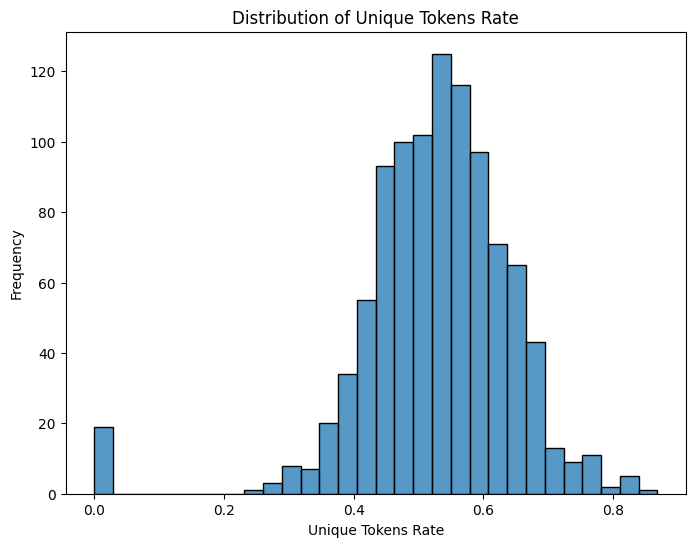

In [42]:
plt.figure(figsize=(8, 6))
sns.histplot(df_news['unique_tokens_rate'], bins=30)
plt.xlabel('Unique Tokens Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Tokens Rate')
plt.show()


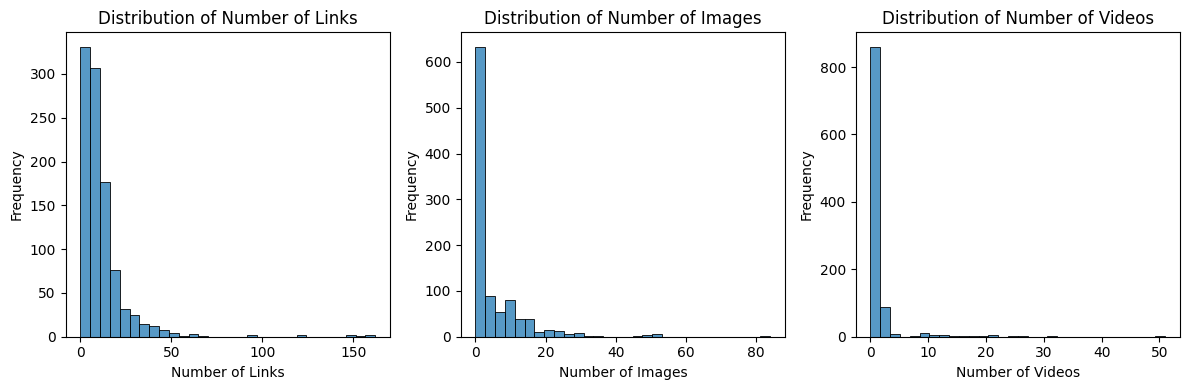

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(df_news['num_hrefs'], bins=30)
plt.xlabel('Number of Links')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Links')

plt.subplot(132)
sns.histplot(df_news['num_imgs'], bins=30)
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Images')

plt.subplot(133)
sns.histplot(df_news['num_videos'], bins=30)
plt.xlabel('Number of Videos')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Videos')

plt.tight_layout()
plt.show()


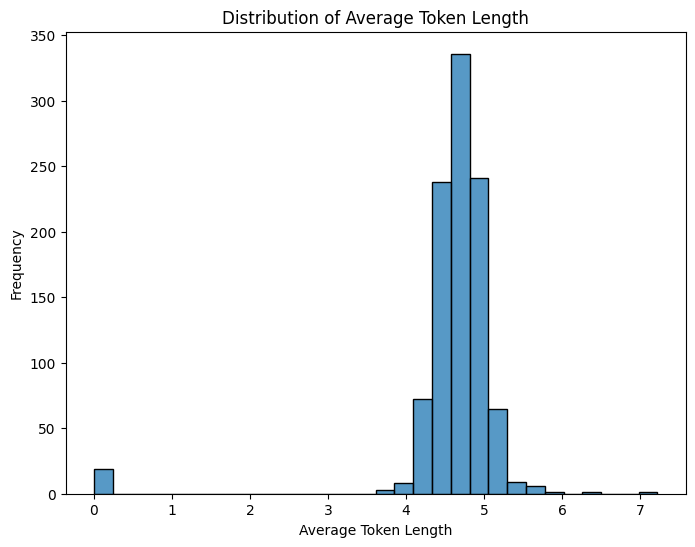

In [44]:
plt.figure(figsize=(8, 6))
sns.histplot(df_news['average_token_length'], bins=30)
plt.xlabel('Average Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Average Token Length')
plt.show()


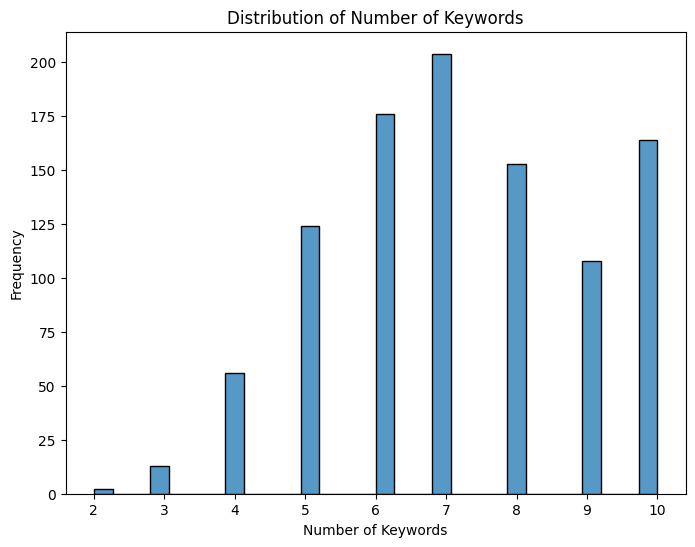

In [45]:
plt.figure(figsize=(8, 6))
sns.histplot(df_news['num_keywords'], bins=30)
plt.xlabel('Number of Keywords')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Keywords')
plt.show()

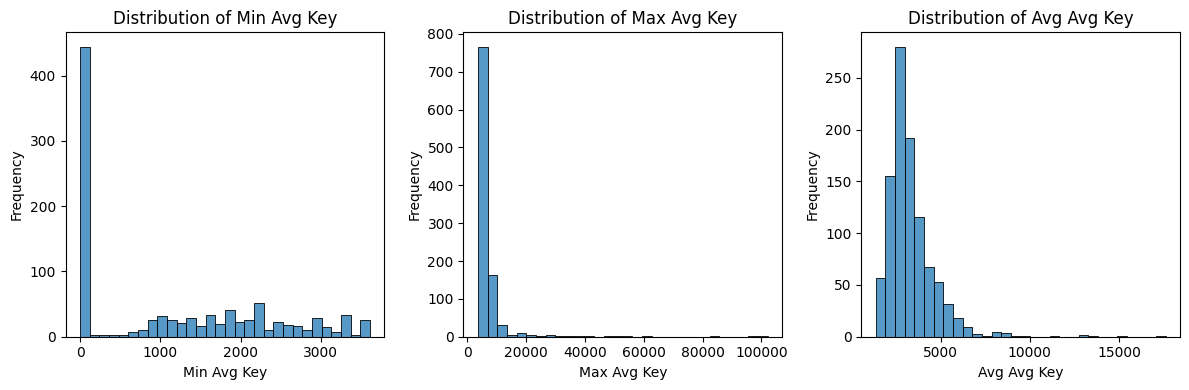

In [46]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(df_news['min_avg_key'], bins=30,)
plt.xlabel('Min Avg Key')
plt.ylabel('Frequency')
plt.title('Distribution of Min Avg Key')

plt.subplot(132)
sns.histplot(df_news['max_avg_key'], bins=30, )
plt.xlabel('Max Avg Key')
plt.ylabel('Frequency')
plt.title('Distribution of Max Avg Key')

plt.subplot(133)
sns.histplot(df_news['avg_avg_key'], bins=30,)
plt.xlabel('Avg Avg Key')
plt.ylabel('Frequency')
plt.title('Distribution of Avg Avg Key')

plt.tight_layout()
plt.show()


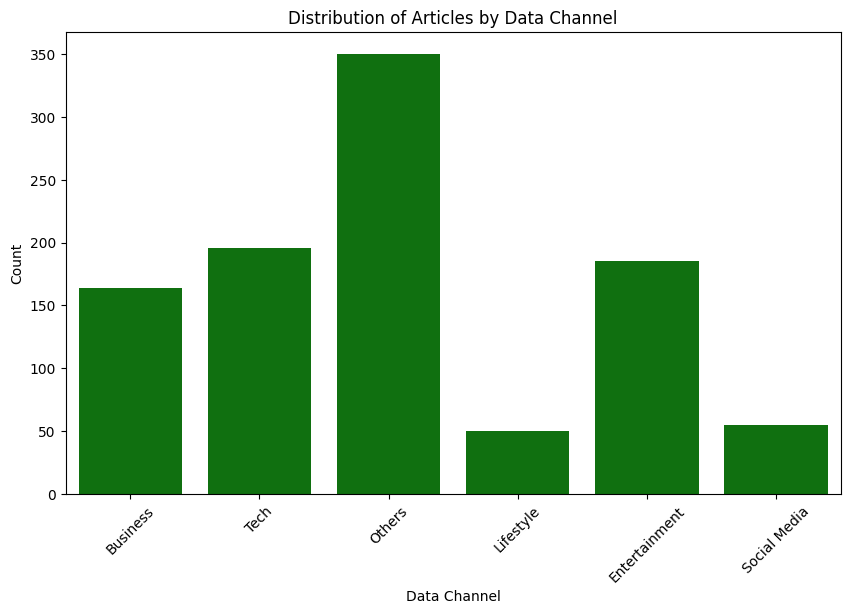

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_news, x='cleaned_data_channel', color = 'g')
plt.xlabel('Data Channel')
plt.ylabel('Count')
plt.title('Distribution of Articles by Data Channel')
plt.xticks(rotation=45)
plt.show()


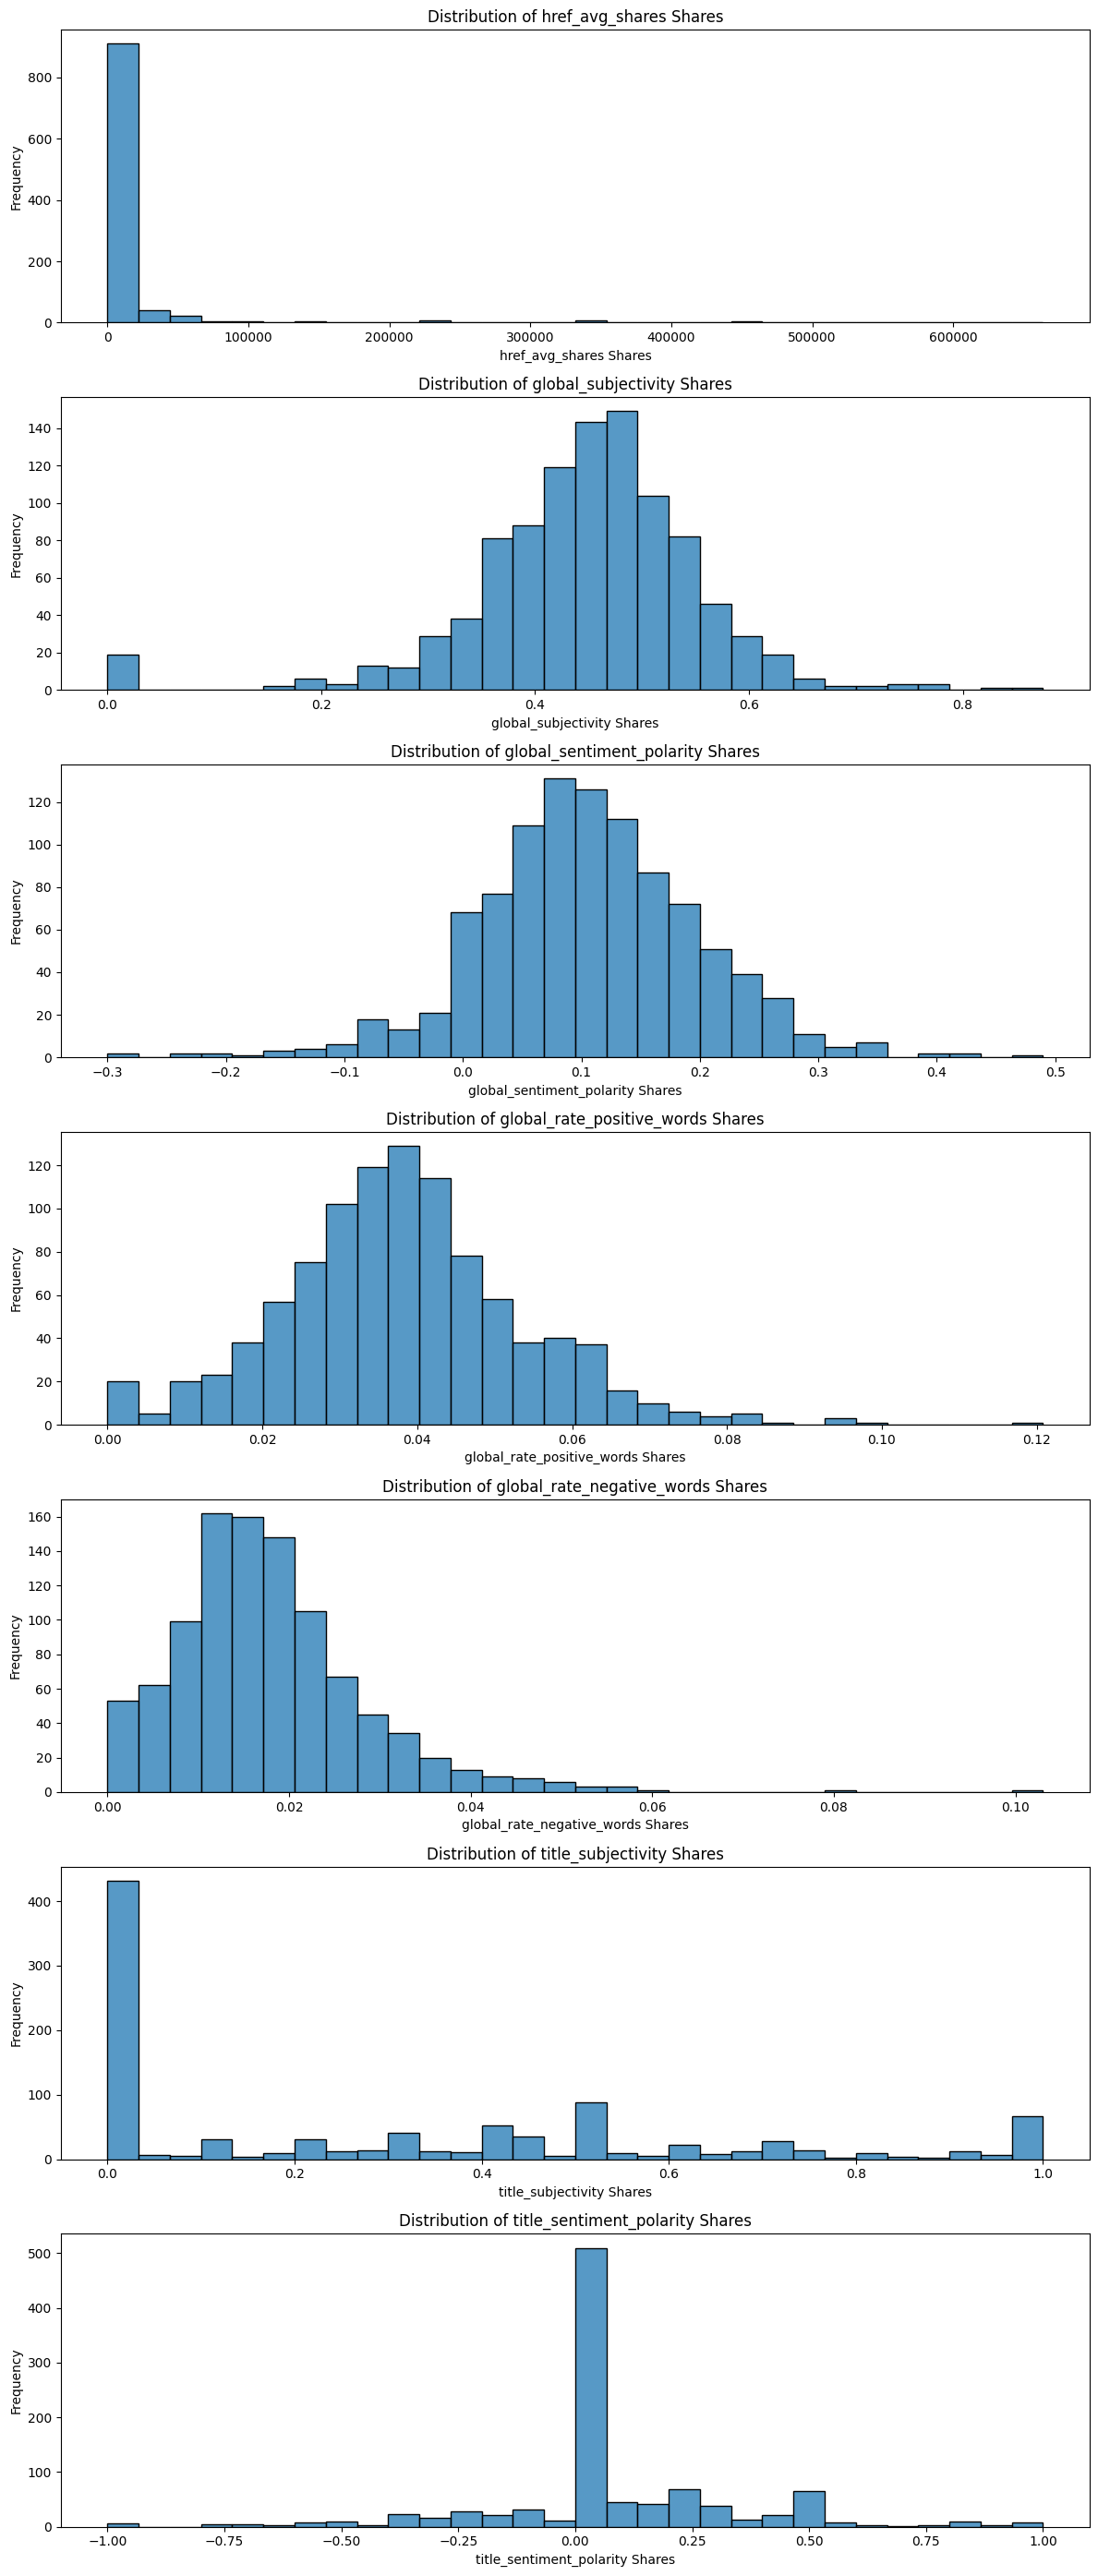

In [50]:
columns_to_plot = ['href_avg_shares', 'global_subjectivity',                   'global_sentiment_polarity', 'global_rate_positive_words',
                   'global_rate_negative_words', 'title_subjectivity',
                   'title_sentiment_polarity']


fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(12, 4 * len(columns_to_plot)))

for i, column_name in enumerate(columns_to_plot):
    sns.histplot(df_news[column_name], bins=30, ax=axes[i])
    axes[i].set_xlabel(f'{column_name} Shares')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {column_name} Shares')

plt.tight_layout()
plt.show()


In [51]:
df_news_final.head(1)

,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,...,shares,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech
0,0.640816,5,3,1,4.579592,5,1459.5,4817.692,3370.415,1833.333,...,1600,Monday,0,March,Business,0,0,0,0,0


In [52]:
df_news['month'].value_counts()

April    999
March      1
Name: month, dtype: int64

In [53]:
'''from sklearn.preprocessing import LabelEncoder

#  label encoders for 'month' and 'weekday'
month_encoder = LabelEncoder()
weekday_encoder = LabelEncoder()

# Fit and transform the 'month' and 'weekday' columns
df_news_final['month number'] = month_encoder.fit_transform(df_news_final['month'])
df_news_final['weekday number'] = weekday_encoder.fit_transform(df_news_final['weekday'])
'''

"from sklearn.preprocessing import LabelEncoder\n\n#  label encoders for 'month' and 'weekday'\nmonth_encoder = LabelEncoder()\nweekday_encoder = LabelEncoder()\n\n# Fit and transform the 'month' and 'weekday' columns\ndf_news_final['month number'] = month_encoder.fit_transform(df_news_final['month'])\ndf_news_final['weekday number'] = weekday_encoder.fit_transform(df_news_final['weekday'])\n"

In [54]:
df_news_final.columns

Index(['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech'],
      dtype='object')

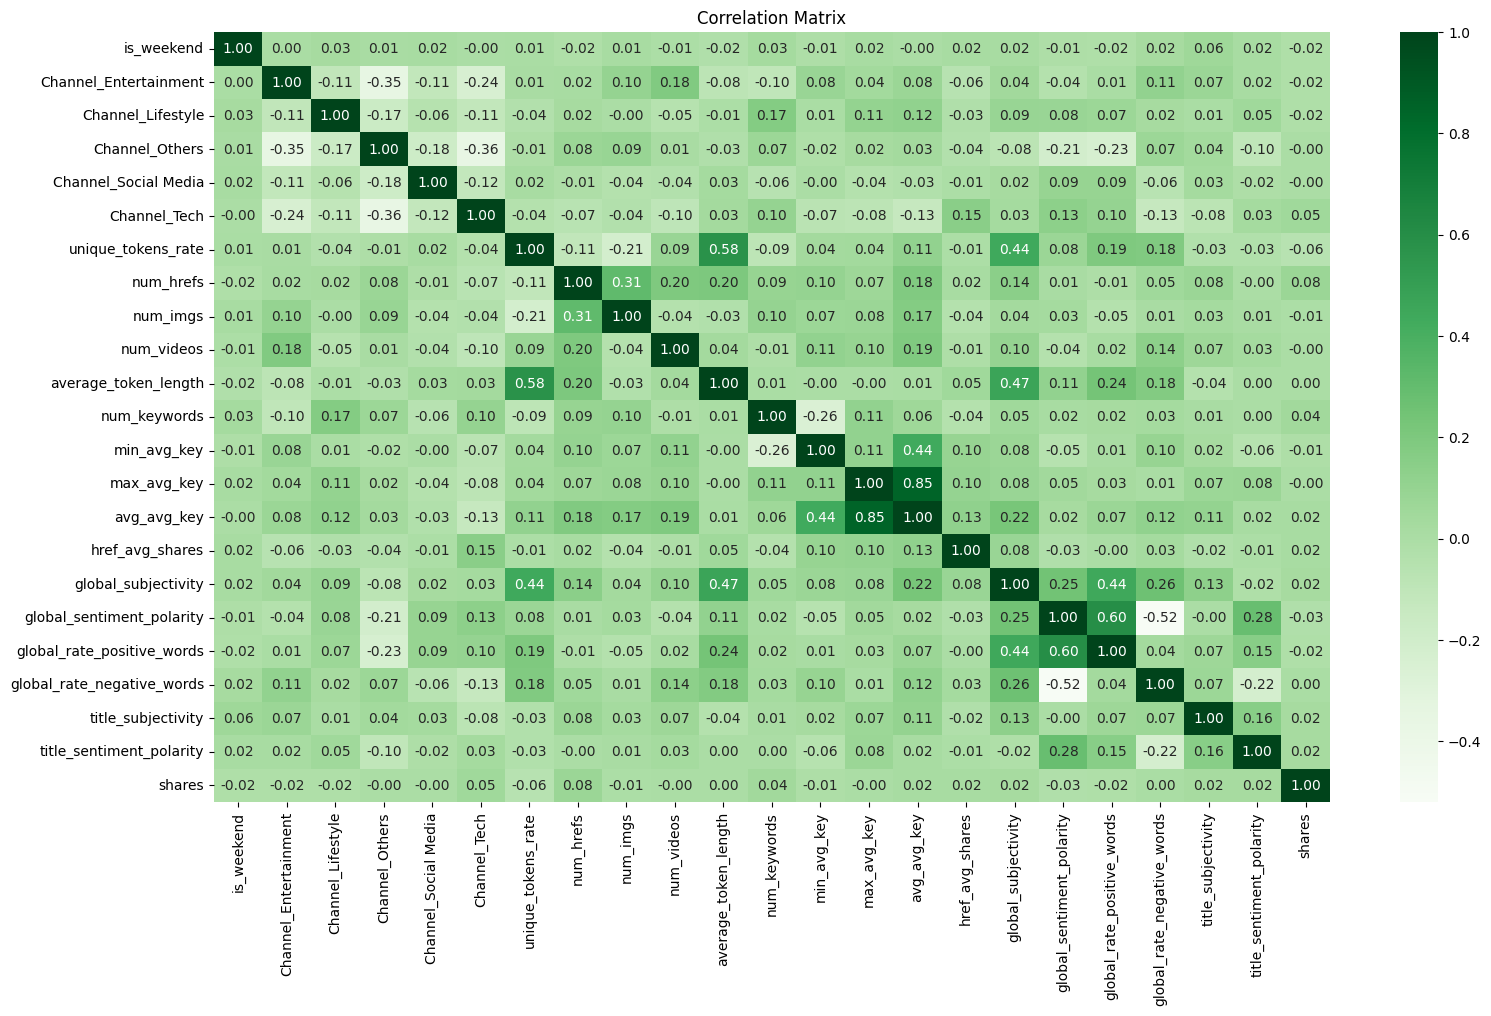

In [55]:
num_news = df_news_final[['is_weekend',
       'Channel_Entertainment', 'Channel_Lifestyle', 'Channel_Others',
       'Channel_Social Media', 'Channel_Tech', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'min_avg_key', 'max_avg_key', 'avg_avg_key',
       'href_avg_shares', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'title_subjectivity', 'title_sentiment_polarity', 'shares']]

correlation_matrix = num_news.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


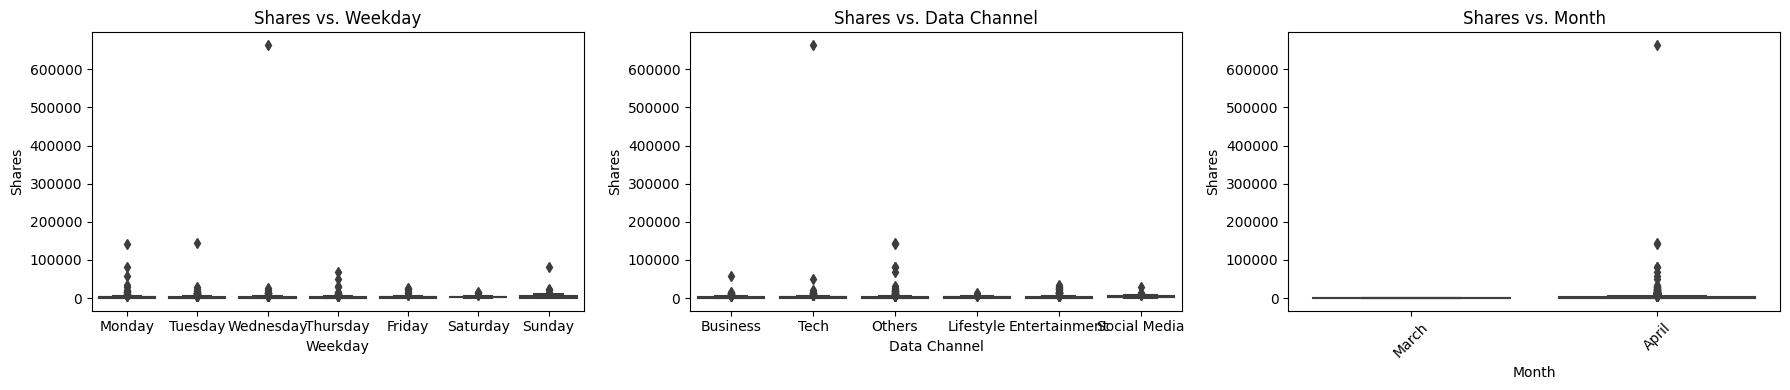

In [56]:
plt.figure(figsize=(18, 4))

# Box plot for 'weekday'
plt.subplot(131)
sns.boxplot(x='weekday', y='shares', data=df_news, orient='v')
plt.xlabel('Weekday')
plt.ylabel('Shares')
plt.title('Shares vs. Weekday')

# Box plot for 'cleaned_data_channel'
plt.subplot(132)
sns.boxplot(x='cleaned_data_channel', y='shares', data=df_news, orient='v')
plt.xlabel('Data Channel')
plt.ylabel('Shares')
plt.title('Shares vs. Data Channel')

# Box plot for 'month'
plt.subplot(133)
sns.boxplot(x='month', y='shares', data=df_news, orient='v')
plt.xlabel('Month')
plt.ylabel('Shares')
plt.title('Shares vs. Month')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


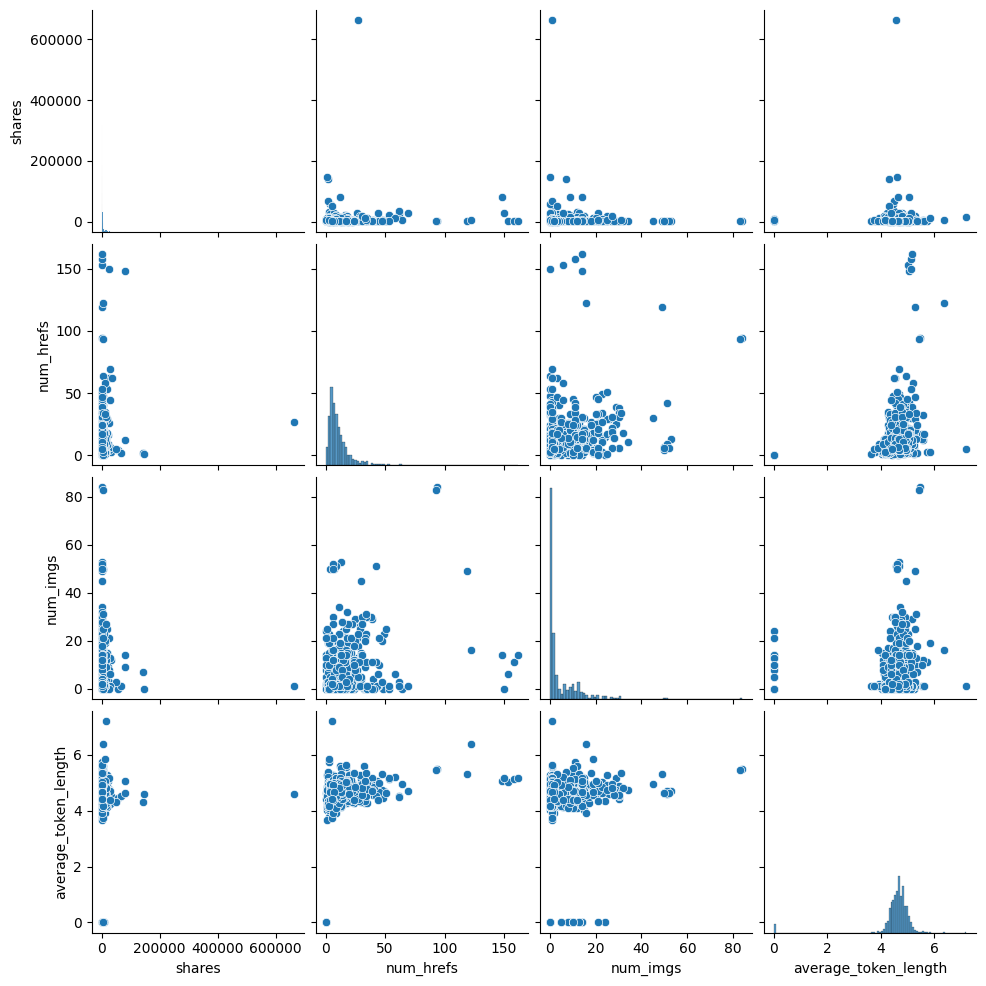

In [57]:
# Pair plots for selected numerical features
sns.pairplot(df_news[['shares', 'num_hrefs', 'num_imgs', 'average_token_length']])
plt.show()



In [58]:
df_news_final.columns

Index(['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech'],
      dtype='object')

In [61]:

df_news['article_id_count'] = df_news.groupby('article_id')['article_id'].transform('count')

duplicate_articles = df_news[df_news['article_id_count'] > 1]

duplicate_articles

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,article_id_count
510,7028680,Dove's Beauty Patch Experiment Wants You to Em...,"On the heels of last year's ""Beauty Sketches"" ...",2014-04-09,0.418367,30,4,1,4.379342,9,...,Wednesday,0,April,Lifestyle,0,1,0,0,0,2
511,7028680,"Dropbox Unveils Project Harmony, Mailbox for A...",Dropbox on Wednesday unveiled a suite of fresh...,2014-04-09,0.316504,42,11,0,4.540550,7,...,Wednesday,0,April,Business,0,0,0,0,0,2


In [62]:
df_news_final = df_news.drop(511, axis=0)
df_news_final[510:513]

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,article_id_count
510,7028680,Dove's Beauty Patch Experiment Wants You to Em...,"On the heels of last year's ""Beauty Sketches"" ...",2014-04-09,0.418367,30,4,1,4.379342,9,...,Wednesday,0,April,Lifestyle,0,1,0,0,0,2
512,7028664,Facebook's Not Messing Around: Messenger Will ...,When Facebook acquired standalone messaging ap...,2014-04-09,0.442667,38,30,1,4.902760,7,...,Wednesday,0,April,Others,0,0,1,0,0,1
513,7028589,Facebook Overhauls and Limits Those Despised R...,When Facebook rolled out its last desktop rede...,2014-04-09,0.608108,6,0,0,4.693694,6,...,Wednesday,0,April,Tech,0,0,0,0,1,1


In [63]:
df_news_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 1002
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   article_id                  999 non-null    int64         
 1   title                       999 non-null    object        
 2   text                        999 non-null    object        
 3   published_date              999 non-null    datetime64[ns]
 4   unique_tokens_rate          999 non-null    float64       
 5   num_hrefs                   999 non-null    int64         
 6   num_imgs                    999 non-null    int64         
 7   num_videos                  999 non-null    int64         
 8   average_token_length        999 non-null    float64       
 9   num_keywords                999 non-null    int64         
 10  data_channel                999 non-null    object        
 11  min_avg_key                 999 non-null    float64      

In [70]:
df_news_final.columns


Index(['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech'],
      dtype='object')

In [71]:
df_news_final

,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel,min_avg_key,max_avg_key,avg_avg_key,...,shares,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech
0,0.640816,5,3,1,4.579592,5,Business,1459.500,4817.692,3370.415,...,1600,Monday,0,March,Business,0,0,0,0,0
1,0.549618,4,1,0,4.636704,7,Tech,0.000,3581.094,2556.367,...,1500,Tuesday,0,April,Tech,0,0,0,0,1
2,0.577236,8,1,0,4.627451,7,Tech,2270.889,3852.800,3018.167,...,1400,Tuesday,0,April,Tech,0,0,0,0,1
3,0.525896,4,1,0,5.083665,9,Tech,0.000,3581.094,1871.403,...,1300,Tuesday,0,April,Tech,0,0,0,0,1
4,0.588889,6,9,0,4.336022,7,00000,3581.094,8453.451,5155.323,...,3000,Tuesday,0,April,Others,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0.606557,6,2,0,4.913978,4,Business,3329.921,5709.823,4020.608,...,1300,Thursday,0,April,Business,0,0,0,0,0
999,0.491018,4,2,0,4.674627,6,Tech,0.000,4352.491,2358.572,...,1100,Thursday,0,April,Tech,0,0,0,0,1
1000,0.634518,3,0,2,4.177665,9,Entertainment,2126.118,6060.771,3296.052,...,4400,Thursday,0,April,Entertainment,1,0,0,0,0
1001,0.447368,7,1,0,4.667961,8,Business,0.000,4763.083,2709.129,...,1900,Thursday,0,April,Business,0,0,0,0,0
